<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="figures/xveganx_icon.png">
*This notebook contains ongoing research material from [gully](https://twitter.com/gully_); the content is available [on GitHub](https://github.com/BrownDwarf/xveganx).*


<!--NAVIGATION-->
< [Periodogram analysis demo of HD 283572](04.02-Boutique-periodogram-analysis-HD283572.ipynb) | [Contents](Index.ipynb) |

# Boutique photometry collection for V827 Tau

Note, this boutique analysis for one target is now deprecated and superceded by our new "master" photometry.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
% matplotlib inline
% config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_context('paper', font_scale=1.4)
sns.set_style('ticks')

In [4]:
import pandas as pd

In [5]:
import sys
import os

In [6]:
sys.path.append(os.path.abspath("../code/"))

In [7]:
import xphotometryx

## Re-run master flatten photometry

In [8]:
xphotometryx.flatten_photometry()

0

In [9]:
master = pd.read_csv('../data/flat_photometry/V827_Tau_flat.csv')

In [10]:
master.shape

(1722, 15)

## Metadata for observing "seasons"

Estimate the period separately for each season:

In [11]:
master['object'] = 'V827 Tau'

In [12]:
df_season = xphotometryx.seasonal_aggregation(master, 'V827 Tau')

In [13]:
df_season.tail()

,season,N_U,N_B,N_V,N_R,JD_min,JD_max,length,years,P_est1,P_err1
20,29,0,40,136,19,2.456490e+06,2.456755e+06,265.0,7/2013-4/2014,3.75837,0.1
21,30,0,0,344,0,2.456855e+06,2.457096e+06,241.0,7/2014-3/2015,3.75837,0.1
22,31,0,0,160,0,2.457227e+06,2.457467e+06,240.0,7/2015-3/2016,3.75837,0.1
23,32,0,6,112,5,2.457588e+06,2.457835e+06,248.0,7/2016-3/2017,3.75837,0.1
24,33,0,1,3,1,2.457965e+06,2.458113e+06,149.0,7/2017-12/2017,3.75837,0.1


## Metadata for observing "epochs"

In [14]:
epochs = pd.read_csv('../data/metadata/IGRINS_hdr_table.csv', usecols=['OBJECT', 'ACQTIME'])

In [15]:
epochs = epochs.rename(columns={'ACQTIME':'JD_like'})
epochs = epochs[epochs.OBJECT=='V827Tau']
epochs['Observation'] = 'IGRINS'
epochs['Instrument'] = 'IGRINS'
epochs = epochs.reset_index(drop=True)

Associate each epoch with the closest season

In [16]:
epochs.JD_like[0]

2456982.724768519

In [17]:
this_i = (epochs.JD_like[0] < df_season.JD_max) & (epochs.JD_like[0] > df_season.JD_min)

In [18]:
df_season.season[this_i]

21    30
Name: season, dtype: int64

In [19]:
epochs['AdoptedSeason'] = 30
epochs['linestyles'] = 'dashed'
epochs['color'] = 'r'

## Lightcurve analysis

In [58]:
master['flux_rel'] = 10**(-1.0*master.Vmag/2.5)
master['flux_rel'] = master['flux_rel'] /np.nanmax(master.flux_rel)

## Full range of data

Photometric sources:

In [59]:
master.JD_like.max()

2458113.25972

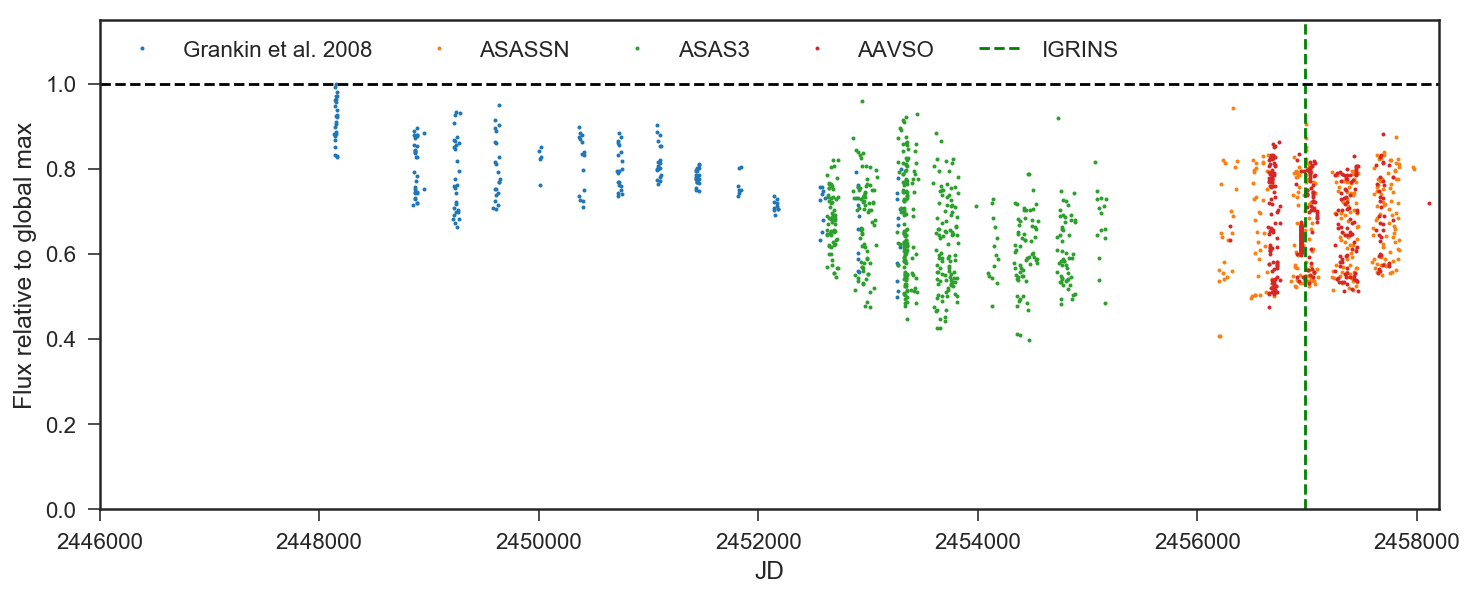

In [73]:
plt.figure(figsize=(12, 4.5))

for source in master.source.unique():
    inds = master.source == source
    plt.plot(master.JD_like[inds], master.flux_rel[inds], '.', ms=4,label=source)

for i in range(len(epochs)):
    label = epochs.Instrument[i]
    plt.axvline(epochs.JD_like[i], label = label, linestyle='dashed', color='green')

plt.axhline(1.0, linestyle='dashed', color='k')

legend = plt.legend(loc='upper left', ncol=5)#, frameon=True, shadow=False, )
plt.ylim(0, 1.15)

plt.ylabel('Flux relative to global max')
plt.xlabel('JD')

plt.xlim(2446000, 2458200)
#plt.xlim(2456920+15., 2456920+30)
plt.savefig('../results/V827_phot1990-2017.pdf', bbox_inches='tight')

In [23]:
from xphotometryx import *

In [51]:
def plot_season_minimum(master, season_agg, epochs, ylim=(0, 1.25), savefig_file='../results/test_min_spot.pdf'):
    '''
    Plots all the available seasons of photometry in phase-folded postage stamps.
    '''
    fig = plt.figure(figsize=(8.5, 11))
    fig.subplots_adjust(hspace=0.1, bottom=0.06, top=0.94, left=0.12, right=0.94)
    n_seasons = len(season_agg.season)
    ylabel='$f_\mathrm{spot, min}$'

    for i in range(n_seasons):
        # get the data and best-fit angular frequency
        s = season_agg.season[i]
        ids = master.season == s
        df = master[ids]
        t = df.JD_like.values
        y = df.flux_rel.values
        dy = df.flux_rel.values*0.02
        #this_P = season_agg.P_est1[i]
        this_P = season_agg.P_est1.median()
        phased_t = np.mod(t, this_P)/this_P

        # Fit a multiterm model
        Nterms = 4
        reg = 0.1 * np.ones(2 * Nterms + 1)
        reg[:5] = 0 # no regularization on low-order terms
        if (s in [11, 33]):
            #Ad-hoc!
            reg = 0.3 * np.ones(2 * Nterms + 1)
            reg[:3] = 0 # no regularization on low-order terms

        modelV = LombScargle(Nterms=4, regularization=reg)
        mask = y == y # We can mask flares later on
        modelV.fit(t[mask], y[mask], dy[mask])
        tfit = np.linspace(0, this_P, 100)
        yfitV = modelV.predict(tfit, period=this_P)


        # plot the phased data
        ax = fig.add_subplot(6,5,1 + i)
        plt.plot(tfit/this_P, yfitV, alpha=0.5)
        ax.errorbar(phased_t, y, dy, fmt='.k', ecolor='gray',
                    lw=1, ms=4, capsize=1.5)

        #---Mark observation epochs---
        ts_ids = (np.float(s) == epochs.AdoptedSeason)
        if ts_ids.sum() > 0:
            for ei in epochs.index.values[ts_ids.values]:
                this_phase = np.mod(epochs.JD_like[ei], this_P)/this_P
                ax.axvline(this_phase, linestyle=epochs.linestyles[ei],
                          color=epochs.color[ei], alpha=0.8)
        #-----------------------------

        ax.yaxis.set_major_locator(plt.MaxNLocator(5))
        ax.set_ylim(ylim)

        ax.text(0.03, 0.96, "{}".format(season_agg.years[i]),ha='left', va='top',
                transform=ax.transAxes, size=11)

        if i < 20 :
            ax.xaxis.set_major_formatter(plt.NullFormatter())
        if i % 5 != 0:
            ax.yaxis.set_major_formatter(plt.NullFormatter())
        if i % 5 == 0:
            ax.set_ylabel(ylabel)

        if i in np.arange(20, 24+1):
            ax.set_xlabel('phase')
        
        #ax.text(0.5, 0.3, s)
    plt.savefig(savefig_file, bbox_inches='tight')

In [52]:
#master = master[master.source != 'Integral-OMC'].reset_index(drop=True)

In [76]:
master[master.Vmag == master.Vmag.min()]

,JD_like,year,month,day,season,Vmag,Verr,Bmag,Berr,Rmag,Rerr,Umag,Uerr,source,date_type,object,flux_rel
17,2.448156e+06,1990,9,21.9687,6,12.242,0.01,13.645,0.01,10.931,0.01,NaN,NaN,Grankin et al. 2008,HJD,V827 Tau,1.0


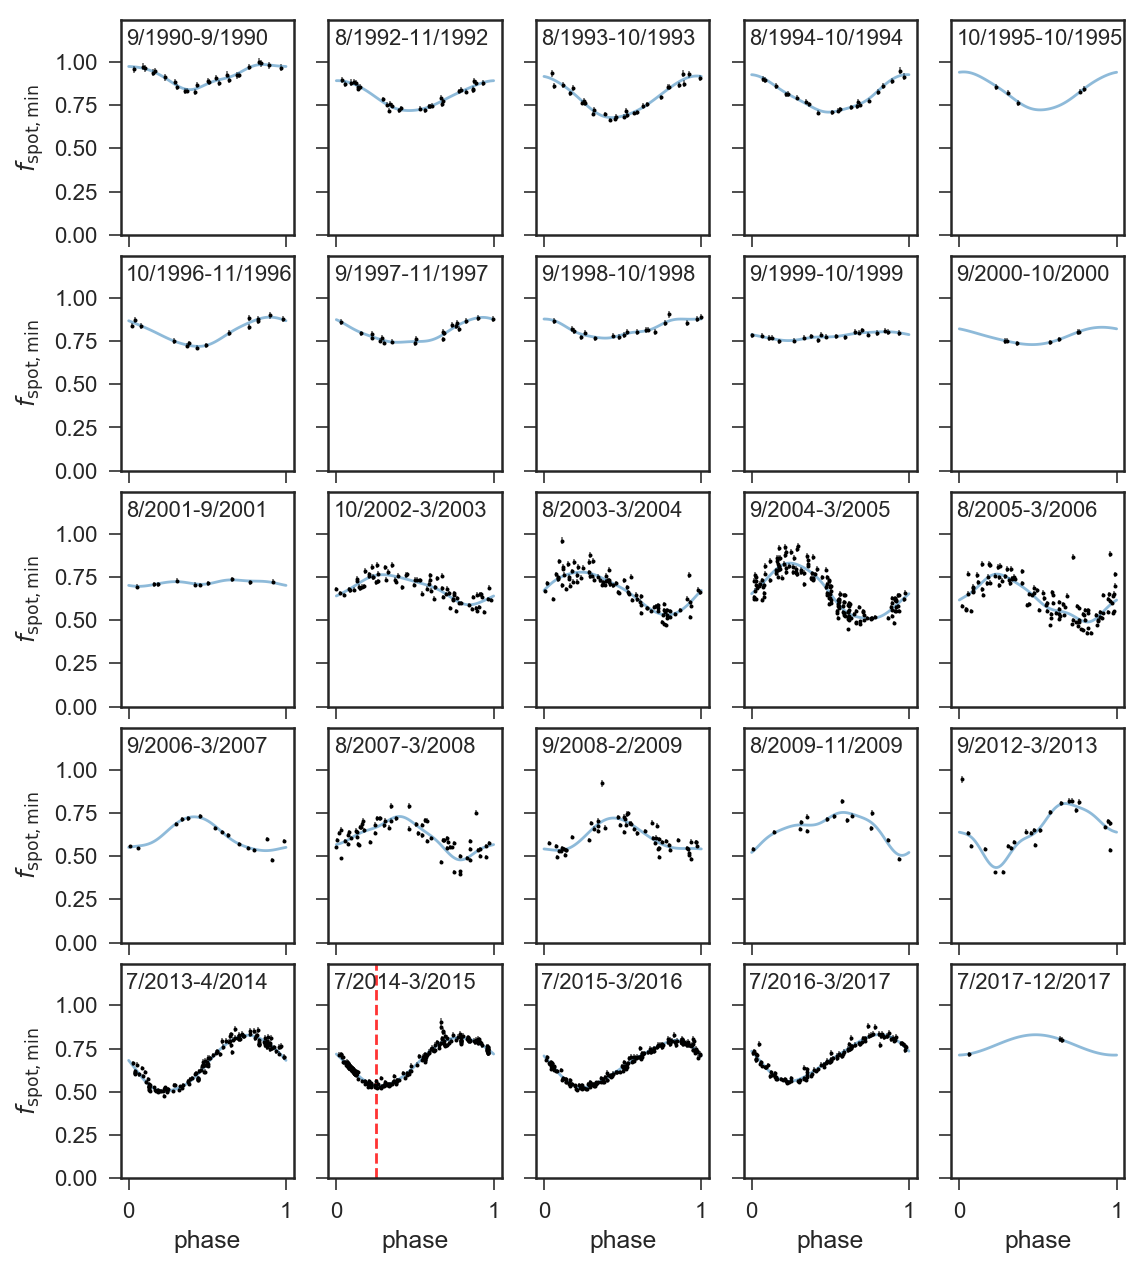

In [62]:
plot_season_minimum(master, df_season, epochs, ylim=(0, 1.24), savefig_file='../results/V827Tau_30season_stamps_V.pdf')

In [70]:
for ids, group in master.groupby('source'):
    print(ids, group.Vmag.notnull().sum())

AAVSO 473
ASAS3 552
ASASSN 306
Grankin et al. 2008 236


Nice!

## Table of estimated $V$ values at the time of observations

In [79]:
master[master.season==32].Vmag.median()

12.636666666666665

In [81]:
eps

,JD-2450000,Instrument,B_est,V_est,R_est
0,6982.724769,IGRINS,NaN,12.925503,NaN


In [82]:
latex_fmts = [lambda x:"{:0.4f}".format(x), lambda x:"{}".format(x), 
        lambda x:"{:0.2f}".format(x), lambda x:"{:0.2f}".format(x), lambda x:"{:0.2f}".format(x)]

In [83]:
tbl_out = eps

In [84]:
print(tbl_out.to_latex(index=False, na_rep='$\cdots$', formatters=latex_fmts))

\begin{tabular}{rlrrr}
\toprule
JD-2450000 & Instrument & B\_est & V\_est & R\_est \\
\midrule
 6982.7248 &     IGRINS &   nan & 12.93 &   nan \\
\bottomrule
\end{tabular}



## The end.

<!--NAVIGATION-->
< [Periodogram analysis demo of HD 283572](04.02-Boutique-periodogram-analysis-HD283572.ipynb) | [Contents](Index.ipynb) |